$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Recommender \space Systems $$
$$ Lab \space no. \space 5 $$

# `00.` Preparation

## `i.` Importing Libraries

In [1]:
import torch
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display, clear_output
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# for reproducibility
import os
import random

def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

## `ii.` Loading Dataset

In [3]:
df = pd.read_csv('/content/DePaulMovies.csv')
df.head()

,userid,itemid,rating,Time,Location,Companion
0,1123,tt1499658,2,NaN,NaN,NaN
1,1123,tt0405422,4,NaN,NaN,NaN
2,1123,tt0109830,5,NaN,NaN,NaN
3,1123,tt0088763,3,NaN,NaN,NaN
4,1123,tt0133093,3,NaN,NaN,NaN


## `iii.` Data Exploration

### `a.` Explore Null Values


In [4]:
nulls= df.isnull().sum()
nulls_df = pd.DataFrame(nulls,index=nulls.index,columns=['NullCount'])
nulls_df['Null Percentage (%)'] = nulls_df['NullCount']*100/df.shape[0]
nulls_df

,NullCount,Null Percentage (%)
userid,0,0.000000
itemid,0,0.000000
rating,0,0.000000
Time,1448,28.713068
Location,1448,28.713068
Companion,1448,28.713068


### `b.` Count Unique Items & Users

In [5]:
print(f"Unique Users: {len(df['userid'].unique())}.")
print(f"Unique Items: {len(df['itemid'].unique())}.")

Unique Users: 97.
Unique Items: 79.


### `c.` Explore Context Variables

In [7]:
context=df[['Time', 'Location', 'Companion']]
context.columns

Index(['Time', 'Location', 'Companion'], dtype='object')

In [8]:
unique_counts = []
unique_values_list = []

for col_name in context.columns:
    column_values = context[col_name].dropna()
    unique_counts.append(column_values.nunique())
    unique_values_list.append(column_values.unique())

uniques = pd.DataFrame({
    'Column Name': context.columns,
    'Unique Value Count': unique_counts,
    'Unique Values': unique_values_list,
}).set_index('Column Name')

In [9]:
uniques

,Unique Value Count,Unique Values
Column Name,,
Time,2,"[Weekday, Weekend]"
Location,2,"[Cinema, Home]"
Companion,3,"[Alone, Family, Partner]"


In [10]:
value_counts=[]
for column in context.columns:
    column_values = context[column].dropna()
    value_counts.append(column_values.value_counts())

In [11]:
value_counts[0]

,count
Time,
Weekend,1845
Weekday,1750


In [12]:
time=pd.DataFrame(value_counts[0])
time

,count
Time,
Weekend,1845
Weekday,1750


In [13]:
location=pd.DataFrame(value_counts[1])
location

,count
Location,
Cinema,1963
Home,1632


In [14]:
Companion=pd.DataFrame(value_counts[2])
Companion

,count
Companion,
Family,1343
Alone,1173
Partner,1079


### `d.` [Optional] Additional Exploration

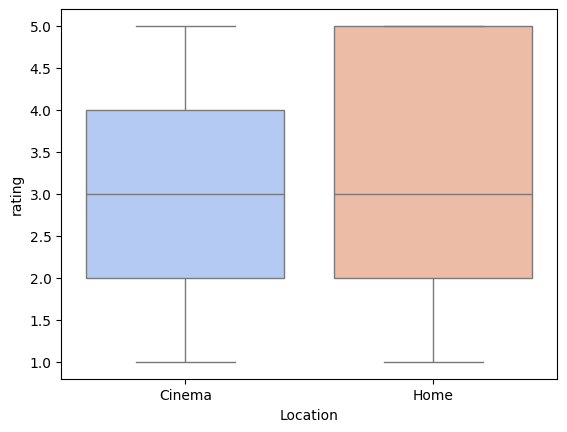

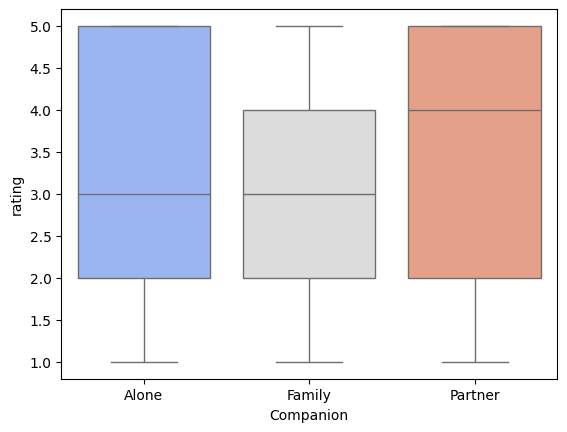

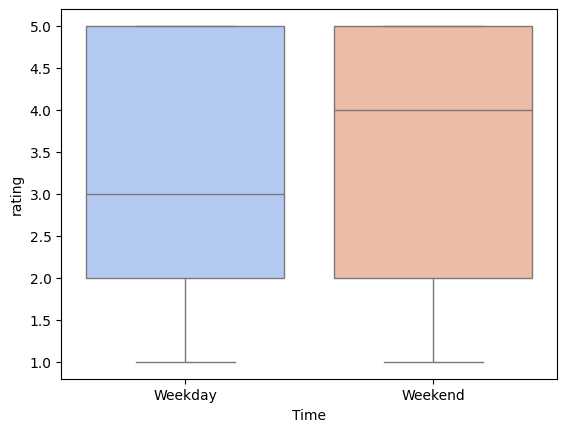

In [15]:
sns.boxplot(data=df, x="Location", y="rating", palette="coolwarm", hue = 'Location', legend = False)
plt.show()
sns.boxplot(data=df, x="Companion", y="rating", palette="coolwarm", hue = 'Companion', legend = False)
plt.show()
sns.boxplot(data=df, x="Time", y="rating", palette="coolwarm", hue = 'Time', legend = False)
plt.show()

-----------------------------------

# `01.` Data Preprocessing

In order to use the data as an input for the Factorization Machine model, we need it to be in a specific format (i.e., active user group, active movie user group, etc...)

In the following cells, we will perform preprocessing steps to extract required information and prepare the feature vector.

## `i.` Create User Mappings

In order to be able to create the active user column group, create the aggregated history column group, ..., etc., we need the users to have a zero-based sequential indexing.

Hence, we will create a user mapping table (to from the new index to the original id).

In [16]:
unique_user_ids = df["userid"].unique()
user_mappings = pd.DataFrame({'new_id': pd.RangeIndex(start=0, stop=len(unique_user_ids))}, index=unique_user_ids).rename_axis('userid')
user_mappings

,new_id
userid,
1123,0
1090,1
1088,2
1110,3
1017,4
...,...
1098,92
1116,93
1032,94


In [17]:
user_mappings.loc[1001]

,1001
new_id,32


## `ii.` Create Movie Mappings

Similar to the users, in order to be able to create the active movie column group, create the aggregated history column group, ..., etc., we need the users to have a zero-based sequential indexing.

Hence, we will create a movie mapping table (to from the new index to the original id).

In [18]:
unique_item_ids = df["itemid"].unique()
movie_mappings = pd.DataFrame({'new_id': pd.RangeIndex(start=0, stop=len(unique_item_ids))}, index=unique_item_ids).rename_axis('itemid')
movie_mappings

,new_id
itemid,
tt1499658,0
tt0405422,1
tt0109830,2
tt0088763,3
tt0133093,4
...,...
tt0489099,74
tt0125439,75
tt0315733,76


## `iii.` Categorical Columns Encoding

In [19]:
cats_ohe = pd.get_dummies(df[["Time","Location","Companion"]])
cats_ohe


,Time_Weekday,Time_Weekend,Location_Cinema,Location_Home,Companion_Alone,Companion_Family,Companion_Partner
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
5038,False,True,False,True,False,False,True
5039,False,True,False,True,False,False,True
5040,False,True,False,True,False,False,True
5041,False,True,False,True,False,False,True


## `iv.` Tagging Transactions into Train and Test Sets

### `#` Select a single transaction per user as a test sample.

**Hint**: Use `cumcount` method (See pandas documentation [here](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.GroupBy.cumcount.html)).

In [20]:
df['Train'] = (df.groupby('userid').cumcount(ascending=False) != 0).replace({True:1, False:0})
df[['userid','itemid','Train']].head()

<ipython-input-20-28875c3c8350>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Train'] = (df.groupby('userid').cumcount(ascending=False) != 0).replace({True:1, False:0})


,userid,itemid,Train
0,1123,tt1499658,1
1,1123,tt0405422,1
2,1123,tt0109830,1
3,1123,tt0088763,1
4,1123,tt0133093,0


## `v.` Create Aggregated History Matrix

In order to create aggregated user history column group, we need to:
- Create a utility matrix (that indicates the movies that each user has rated **in the training set**).
- Make sure the values filled in the utility matrix don't reflect ratings (i.e. binary, either 1 if rated or 0 if not).
- Normalized the matrix values (we can fo that through dividing by the number of movies rated).

In [21]:
df_copy = df.copy() # To avoid changing the original DataFrame
df_copy['ones'] = 1
# .to_dict() returns the pd.Series items as key value pairs {'index_label': value},
# in case of user_mappings.new_id the return value will include {1123: 0, 1090: 1} etc.
df_mapped = df_copy.replace(user_mappings.new_id.to_dict()).replace(movie_mappings.new_id.to_dict())
# Replace None with the appropriate values
agg_history = pd.pivot_table(df_mapped,
               values='rating', index='userid', columns='itemid', fill_value=0)
agg_history = agg_history.applymap(lambda x: 1 if x > 0 else x)
agg_history = agg_history.astype(int)
agg_history

<ipython-input-21-27842478c9ce>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df_copy.replace(user_mappings.new_id.to_dict()).replace(movie_mappings.new_id.to_dict())
<ipython-input-21-27842478c9ce>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  agg_history = agg_history.applymap(lambda x: 1 if x > 0 else x)


itemid,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,1,1,1,0,1,1,1,0,1,0,0,0,1,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0
93,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
94,1,1,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1,1,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0


In [22]:
# Replace None with correct values
# We need to normalize the aggregated history by dividing each value by the sum of all the values in the same row
agg_history_norm = agg_history / agg_history.values.sum(axis=1, keepdims=True)
agg_history_norm

itemid,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## `vi.` Preparing `OneHotEncoder` for Active Columns Group

In [23]:
user_item_pairs = df[['userid','itemid']].replace(user_mappings.new_id.to_dict()).replace(movie_mappings.new_id.to_dict())
user_item_pairs

<ipython-input-23-2621179f7234>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_item_pairs = df[['userid','itemid']].replace(user_mappings.new_id.to_dict()).replace(movie_mappings.new_id.to_dict())


,userid,itemid
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
5038,96,53
5039,96,68
5040,96,67
5041,96,51


In [24]:
active_ohe = OneHotEncoder(sparse_output=False).fit(user_item_pairs)

### `#` Testing with a sample DataFrame

In [25]:
sample_df = pd.DataFrame({'userid': [0], 'itemid': [5], 'any_other_features': ['values']})
sample_df

,userid,itemid,any_other_features
0,0,5,values


In [26]:
pd.DataFrame(
    active_ohe.transform(
        sample_df[active_ohe.feature_names_in_]
        ),
    columns=active_ohe.get_feature_names_out()
    )

,userid_0,userid_1,userid_2,userid_3,userid_4,userid_5,userid_6,userid_7,userid_8,userid_9,userid_10,userid_11,userid_12,userid_13,userid_14,userid_15,userid_16,userid_17,userid_18,userid_19,userid_20,userid_21,userid_22,userid_23,userid_24,userid_25,userid_26,userid_27,userid_28,userid_29,userid_30,userid_31,userid_32,userid_33,userid_34,userid_35,userid_36,userid_37,userid_38,userid_39,userid_40,userid_41,userid_42,userid_43,userid_44,userid_45,userid_46,userid_47,userid_48,userid_49,userid_50,userid_51,userid_52,userid_53,userid_54,userid_55,userid_56,userid_57,userid_58,userid_59,userid_60,userid_61,userid_62,userid_63,userid_64,userid_65,userid_66,userid_67,userid_68,userid_69,userid_70,userid_71,userid_72,userid_73,userid_74,userid_75,userid_76,userid_77,userid_78,userid_79,userid_80,userid_81,userid_82,userid_83,userid_84,userid_85,userid_86,userid_87,userid_88,userid_89,userid_90,userid_91,userid_92,userid_93,userid_94,userid_95,userid_96,itemid_0,itemid_1,itemid_2,itemid_3,itemid_4,itemid_5,itemid_6,itemid_7,itemid_8,itemid_9,itemid_10,itemid_11,itemid_12,itemid_13,itemid_14,itemid_15,itemid_16,itemid_17,itemid_18,itemid_19,itemid_20,itemid_21,itemid_22,itemid_23,itemid_24,itemid_25,itemid_26,itemid_27,itemid_28,itemid_29,itemid_30,itemid_31,itemid_32,itemid_33,itemid_34,itemid_35,itemid_36,itemid_37,itemid_38,itemid_39,itemid_40,itemid_41,itemid_42,itemid_43,itemid_44,itemid_45,itemid_46,itemid_47,itemid_48,itemid_49,itemid_50,itemid_51,itemid_52,itemid_53,itemid_54,itemid_55,itemid_56,itemid_57,itemid_58,itemid_59,itemid_60,itemid_61,itemid_62,itemid_63,itemid_64,itemid_65,itemid_66,itemid_67,itemid_68,itemid_69,itemid_70,itemid_71,itemid_72,itemid_73,itemid_74,itemid_75,itemid_76,itemid_77,itemid_78
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## `vii.` Putting it all together

### `#` Concatenate the Columns Created Independently

Preview the New Dataframe Containing:
- Mapped `userid` and `itemid`
- Encoded Categorical Columns `Time`, `Location`, `Companion`
- Training Data Tag Column
- Target Column `rating`

In [27]:
new_df = pd.concat([df_mapped[["userid","itemid"]], cats_ohe, df[["Train","rating"]]], axis=1)
new_df

,userid,itemid,Time_Weekday,Time_Weekend,Location_Cinema,Location_Home,Companion_Alone,Companion_Family,Companion_Partner,Train,rating
0,0,0,False,False,False,False,False,False,False,1,2
1,0,1,False,False,False,False,False,False,False,1,4
2,0,2,False,False,False,False,False,False,False,1,5
3,0,3,False,False,False,False,False,False,False,1,3
4,0,4,False,False,False,False,False,False,False,0,3
...,...,...,...,...,...,...,...,...,...,...,...
5038,96,53,False,True,False,True,False,False,True,1,1
5039,96,68,False,True,False,True,False,False,True,1,2
5040,96,67,False,True,False,True,False,False,True,1,1
5041,96,51,False,True,False,True,False,False,True,1,1


### `#` Preview the Normalized Aggregated History Matrix

In [28]:
agg_history_norm

itemid,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### `#` Split Data into Training and Test Dataframes

**Hint**: Use `Train` Column

In [29]:
train = new_df[new_df["Train"]==1]
test = new_df[new_df["Train"]==0]
print('The dimensions of the training subset: ', train.shape[0], 'X', train.shape[1])
print('The dimensions of the test subset: ', test.shape[0], 'X', test.shape[1])

The dimensions of the training subset:  4946 X 11
The dimensions of the test subset:  97 X 11


-----------------------

# `02.` Torch Dataset and DataLoader

## `i.` Create Customized Dataset Class

Make sure the `__getitem__` method does the following before returning the data:
- One Hot Encode the `userid` and `itemid` to create active user and active movie column groups respectively.
- Concatenates the redundent rows -corresponding to the `userid` column- from the normalized aggregated history matrix.
- Convert the data into sparse format (to avoid exceeding memory capacity).

**Note**: The Dataset will take an input of:
- User Ids: This is the set of user ids that will be used to split the batches
- Features Dataframe: Contains the data features (except for the aggregated history columns)
- Normalized Aggregated History Matrix
- Active Encoder (i.e. one-hot encoder fit on `userid` and `itemid`)
- Boolean variable indicating whether this dataset is for training/validation (having ground truth) or recommendation (no ground truth)

In [30]:
class DPMovieDataset(Dataset):
  def __init__(self, user_ids, data, agg_hist, active_matrix, recommendation=False):
    self.user_ids = user_ids
    self.data = data
    self.agg_hist = agg_hist
    self.active_matrix = active_matrix
    self.recommendation = recommendation

  def __len__(self):
    return self.user_ids.shape[0]

  def __getitem__(self, idx):
    batch_data = self.data[self.data["userid"].isin(idx)] # Select the rows corresponding to the list of user indices `idx` from self.data dataframe
    cat_cols = batch_data.iloc[:,2:9] # From batch_data extract only the one-hot encoded categorical columns
    agg_history = batch_data[['userid']].merge(self.agg_hist, left_on='userid', right_index=True) # Get the aggregated history for each selected transaction using merge
    active_groups = self.active_matrix.loc[self.active_matrix.index.isin(batch_data.index)] # Select the rows corresponding to the indices of the transactions selected in batch_data

    features = torch.from_numpy(np.hstack((active_groups.values, agg_history.values, cat_cols.values))) # Concatenate the processed columns together horizontally

    if not self.recommendation:
      targets = batch_data['rating']
      return features, targets
    else:
      return features

## `ii.` Instantiate Train and Test Objects from the Custom Dataset



In [31]:
active_columns = pd.get_dummies(new_df[['userid','itemid']].astype(str))
dataset_train = DPMovieDataset(user_mappings.values, train, agg_history_norm, active_columns)
dataset_test = DPMovieDataset(user_mappings.values, test, agg_history_norm, active_columns)

## `iii.` Create the DataLoader for Train and Test Datasets

**Note**: `BatchSampler` is used to select the mini batch at one go; since the `DataLoader` samples the batch items one by one
 causing an error when concatenating (because each item in our case represents a user with different transaction count; meaning the items don't have
 consistent shapes).


**Note**: `BatchSampler` can have either another sampler or list of indices to select from. In our case, we used `SequentialSampler` which generates selections from 0 to M (number of users) in subsets of batch_size.

In [32]:
dataloader_train = DataLoader(dataset_train,
                              sampler=BatchSampler(SequentialSampler(dataset_train), batch_size=10, drop_last=False),
                              batch_size=None)

dataloader_test = DataLoader(dataset_test,
                              sampler=BatchSampler(SequentialSampler(dataset_test), batch_size=10, drop_last=False),
                              batch_size=None)

----------------------------------------------

# `03.` Torch Model Implementation

## `#` Model Equation Review

The 2-way factorization machine can be defines as:
$$\hat{y}(x) = w_0 + \sum_{i=1}^{n}w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \textbf v_i, \textbf v_j \rangle x_i x_j$$

<br>
The first term is just a linear model (i.e. can be replaced with a linear layer). The interaction part though can be reformulated into:

$$\sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \textbf v_i, \textbf v_j \rangle x_i x_j =
\frac{1}{2} \sum_{f=1}^{k} \Big( \big(\sum_{i=1}^{n} v_f^{(i)} x_i \big)^2 - \sum_{i=1}^{n}v_f^{(i) 2} x_i^2 \Big)
$$

<br>

If we define $X$ and $V$ as follows:

<br>

$$
X = \begin{bmatrix}
x_1^{(1)} & \dots & x_n^{(1)}\\
 \vdots \ & \ddots \ & \vdots \\
x_1^{(M)} & \dots & x_n^{(M)} \\
\end{bmatrix}, \space \space
V = \begin{bmatrix}
v_1^{(1)} & \dots & v_k^{(1)}\\
 \vdots \ & \ddots \ & \vdots \\
v_1^{(n)} & \dots & v_k^{(n)} \\
\end{bmatrix}
$$

<br>

where $M$ is the number of transactions, $n$ is the number of features, and $k$ is the hyperparameter defining the latent space dimensions.

<br><br>
Then the interaction term can be put in the following vectorized form:

$$\sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \textbf v_i, \textbf v_j \rangle x_i x_j =
\frac{1}{2} \sum^{M} \Big( \big(XV\big)^{2} - \big(X^{2}V^{2}\big) \Big)
$$

<br>

where $\sum\limits^{M}$ represents a row-wise summation.

## `i.` Create the Model Class

Implement Factorization Machines using PyTorch Class Model:
- Linear Layer: Represents the variable strengths
- V Matrix: Latent Representation Matrix for each variable
- Implement the FM calculations in the `forward` method

In [33]:
class FactorizationMachine(torch.nn.Module):
  def __init__(self, n, k, bias=False):
    super(FactorizationMachine, self).__init__()
    self.n = n
    self.k = k
    self.linear = torch.nn.Linear(self.n, 1, bias)
    self.V = torch.nn.Parameter(torch.randn(n,k)) # Creating the latent matrix V of size (n X k) and initializing it with random values

  def forward(self, x_batch):
    x_batch = x_batch.float()
    part_1 = torch.sum(torch.pow(torch.mm(x_batch, self.V), 2), dim=1, keepdim=True)  # perform the first part of the interaction term: row-wise-sum((XV)^2)
    part_2 = torch.sum(torch.mm(torch.pow(x_batch, 2), torch.pow(self.V, 2)), dim=1, keepdim=True) # perform the second part of the interaction term: row-wise-sum((X)^2 * (V)^2))
    inter_term = 0.5 * torch.sub(part_1, part_2) # Put the interaction term parts together (refer to the equations above)
    var_strength = self.linear(x_batch) # Perform the linear part of the model equation (refer to the demo notebook on how to use layers in pytorch models)
    return var_strength + inter_term

## `ii.` Instantiate a Model Object

As for the hyperparameters:
- `n`: No. of features in the final feature vector
- `k`: No. of latent features in the `V` matrix

**Note**: You may try $k=5$ and observe the results.

In [34]:
# Hint: This is how you can check the no. features in our dataset
for x,y in dataloader_train:
    print(x[0].shape)

torch.Size([263])
torch.Size([263])
torch.Size([263])
torch.Size([263])
torch.Size([263])
torch.Size([263])
torch.Size([263])
torch.Size([263])
torch.Size([263])
torch.Size([263])


In [35]:
#model = FactorizationMachine(n=263, k=5)
#model = FactorizationMachine(n=x.shape[1], k=5)
model = FactorizationMachine(n=263, k=5)


------------------------

# `04.` Training the Model

## `i.` Write a Function to Run a Single Step of Training

Parameters:
- Model [torch model]
- Optimizer [torch.optim optimizer]
- Faetures [matrix]
- Targets [vector]
- Train [bool]: Whether this is a training or an evaluation step

In [36]:
def model_step(mode, x, y=None, optimizer=None, train=True):
  if train: # If we're in training phase, then zero the gradients and make sure the model is set to train
    model.train()
    optimizer.zero_grad()
  else: # If we're in evaluation phase, then make sure the model is set to eval
    model.eval()

  with torch.set_grad_enabled(train): # Either to perform the next lines with gradient tracing or not
    pred = model(x) # Get the model output from x
    pred = pred.reshape(pred.shape[0], ) # Flatten the prediction values

    y = torch.from_numpy(y.values.reshape(y.shape[0], )).float()

    criterion = torch.nn.MSELoss() # Define the criterion as MSELoss from torch
    loss = criterion(pred, y)

    if train:
      loss.backward()
      optimizer.step()

  return loss

## `ii.` Write a Function to Simulate the Training Loop of the Model

Parameters:
- Model [torch model]
- Training Dataloader [torch DataLoader]
- Test/Eval Dataloader [torch DataLoader]
- Learning Rate [float]
- Weight Decay [float]
- Epochs [int]
- Eval Step [int]


In [37]:
def train_loop(model, train_loader, eval_loader, lr, w_decay, epochs, eval_step):
  step = 0
  """ Defining our optimizer """
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=w_decay)
  epochs_l, steps, t_losses, v_losses = [], [], [], []

  epochs_tqdm = tqdm(range(epochs), desc='Training in Progress', leave=True)
  for epoch in epochs_tqdm:
    for x, y in train_loader:
      loss_batch = model_step(model, x, y, optimizer, train=True)
      step +=1
      if step % eval_step == 0:
        train_loss = loss_batch
        val_loss = 0
        for x, y in eval_loader:
          val_loss += model_step(model, x, y, train=False)


        epochs_l.append(epoch+1)
        steps.append(step)
        t_losses.append(train_loss.detach().numpy())
        v_losses.append(val_loss.detach().numpy())
        clear_output(wait=True)
        display(pd.DataFrame({'Epoch': epochs_l, 'Step': steps, 'Training Loss': t_losses, 'Validation Loss': v_losses}))

In [38]:
train_loop(model, dataloader_train, dataloader_test, lr=0.004, w_decay=0.0003, epochs=2500, eval_step=2500)

,Epoch,Step,Training Loss,Validation Loss
0,250,2500,9.598226,152.59982
1,500,5000,6.718166,104.11349
2,750,7500,4.604767,77.65272
3,1000,10000,3.225592,60.444736
4,1250,12500,2.2827845,46.617283
5,1500,15000,5.2563386,32.11446
6,1750,17500,2.17436,21.160742
7,2000,20000,1.3496602,17.908054
8,2250,22500,1.1264513,13.107088
9,2500,25000,1.0747792,12.013774


Training in Progress: 100%|██████████| 2500/2500 [03:39<00:00, 11.40it/s]


-------------------------

# `05.` Recommendation



## `i.` Evaluating Model on Test Transaction

Evaluate the model on `userid`$=1053$ from the test dataset

**Note**: Make sure this transaction is not in your training set (if it's, then evaluate the test transaction for this user)

In [39]:
new_id = user_mappings.loc[1053].values[0]
new_id

np.int64(86)

In [40]:
features,actual_rating = dataset_test.__getitem__([new_id])
actual_rating = actual_rating.values[0]
predicted_rating = model(features)[0][0]

In [41]:
model.eval()
with torch.no_grad():
  print(f'Predicted rating for User of interest: {predicted_rating}') # Get the model output on the user of interest after running the previous cell to now their new_id
  print(f'Actual Rating: {actual_rating}') # Extract the actual rating for the user of interest from dataset_test Dataset object

Predicted rating for User of interest: 1.368636131286621
Actual Rating: 1


## `ii.` Recommending New Items

Create a dataframe containing dummy transactions involving user `userid`$=1053$ and movies they didn't rate before.

### `#` Get a list of movies not rated before

In [42]:
# Replace None with the new_id of the user
items_our_user_rated = (train[train.userid==new_id].itemid).unique().tolist()
items_our_user_rated.extend((test[test.userid==new_id].itemid).unique().tolist())

In [43]:
items_our_user_can_rate = movie_mappings[~movie_mappings.new_id.isin(items_our_user_rated)].new_id.tolist()

In [44]:
print(f'Number of unique items user of interest rated is {len(items_our_user_rated)}')
print(f'Number of unique items that can be recommended to user of interest is {len(items_our_user_can_rate)}')

print(f'Preview of the item list:\n\t{items_our_user_can_rate[:5]}')

Number of unique items user of interest rated is 25
Number of unique items that can be recommended to user of interest is 55
Preview of the item list:
	[0, 1, 4, 5, 8]


### `#` Generate a list of all possible pairs of movies with the different contexual features
- `Time`: [Time_Weekday, Time_Weekend]
- `Location`: [Location_Cenima, Location_Home]
- `Companion`: [Companion_Alone, Companion_Family, Companion_Partner]

**Hint**: you can use `itertools.product` function (Not familar? see [Explanation](https://www.geeksforgeeks.org/python-itertools-product/))

In [45]:
possible_pairs = product(items_our_user_can_rate, ['Time_Weekday', 'Time_Weekend'], ['Location_Cinema', 'Location_Home'], ['Companion_Alone', 'Companion_Family', 'Companion_Partner'])

### `#` Create a `DataFrame` where each row represents a possible pair

**Hint 1**: DataFrames can be created from a list of dictionaries (refer to an example [here](https://stackoverflow.com/questions/20638006/convert-list-of-dictionaries-to-a-pandas-dataframe))

**Hint 2**: [List comprehensions](https://www.w3schools.com/python/python_lists_comprehension.asp) can be used with [f-strings](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/) to create a list of dictionaries where each row has $1$s in certain columns and $0$s elsewhere

In [49]:
#data_column_order = train.drop(columns=['Train', 'rating']).columns.tolist()
#data_column_order

['userid', 'itemid']

In [46]:
# Replace None with the new_id of the user of interest
new_recommendation_pairs = pd.DataFrame([{'userid': new_id, 'itemid': t[0], 'userid_86': 1, f'itemid_{t[0]}': 1, f'{t[1]}': 1, f'{t[2]}': 1, f'{t[3]}': 1} for t in possible_pairs])
print(f'Shape of the resulting DataFrame: {new_recommendation_pairs.shape[0]} X {new_recommendation_pairs.shape[1]}')
new_recommendation_pairs.head()

Shape of the resulting DataFrame: 660 X 65


,userid,itemid,userid_86,itemid_0,Time_Weekday,Location_Cinema,Companion_Alone,Companion_Family,Companion_Partner,Location_Home,Time_Weekend,itemid_1,itemid_4,itemid_5,itemid_8,itemid_9,itemid_10,itemid_11,itemid_12,itemid_13,itemid_14,itemid_15,itemid_16,itemid_20,itemid_24,itemid_25,itemid_26,itemid_28,itemid_29,itemid_30,itemid_32,itemid_33,itemid_35,itemid_36,itemid_37,itemid_38,itemid_42,itemid_44,itemid_45,itemid_46,itemid_47,itemid_48,itemid_49,itemid_50,itemid_53,itemid_54,itemid_55,itemid_57,itemid_58,itemid_59,itemid_60,itemid_61,itemid_62,itemid_63,itemid_64,itemid_65,itemid_67,itemid_68,itemid_69,itemid_70,itemid_72,itemid_75,itemid_76,itemid_77,itemid_78
0,86,0,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86,0,1,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86,0,1,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86,0,1,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86,0,1,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
recommendation_pairs_ohe = pd.concat([new_recommendation_pairs, pd.DataFrame([], columns=active_columns.columns)])

<ipython-input-47-4afa1dfe033e>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recommendation_pairs_ohe = pd.concat([new_recommendation_pairs, pd.DataFrame([], columns=active_columns.columns)])


In [48]:
active_columns_rec = recommendation_pairs_ohe.copy()[active_columns.columns].fillna(0)
active_columns_rec.head()

<ipython-input-48-00b3df2bb920>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  active_columns_rec = recommendation_pairs_ohe.copy()[active_columns.columns].fillna(0)


,userid_0,userid_1,userid_10,userid_11,userid_12,userid_13,userid_14,userid_15,userid_16,userid_17,userid_18,userid_19,userid_2,userid_20,userid_21,userid_22,userid_23,userid_24,userid_25,userid_26,userid_27,userid_28,userid_29,userid_3,userid_30,userid_31,userid_32,userid_33,userid_34,userid_35,userid_36,userid_37,userid_38,userid_39,userid_4,userid_40,userid_41,userid_42,userid_43,userid_44,userid_45,userid_46,userid_47,userid_48,userid_49,userid_5,userid_50,userid_51,userid_52,userid_53,userid_54,userid_55,userid_56,userid_57,userid_58,userid_59,userid_6,userid_60,userid_61,userid_62,userid_63,userid_64,userid_65,userid_66,userid_67,userid_68,userid_69,userid_7,userid_70,userid_71,userid_72,userid_73,userid_74,userid_75,userid_76,userid_77,userid_78,userid_79,userid_8,userid_80,userid_81,userid_82,userid_83,userid_84,userid_85,userid_86,userid_87,userid_88,userid_89,userid_9,userid_90,userid_91,userid_92,userid_93,userid_94,userid_95,userid_96,itemid_0,itemid_1,itemid_10,itemid_11,itemid_12,itemid_13,itemid_14,itemid_15,itemid_16,itemid_17,itemid_18,itemid_19,itemid_2,itemid_20,itemid_21,itemid_22,itemid_23,itemid_24,itemid_25,itemid_26,itemid_27,itemid_28,itemid_29,itemid_3,itemid_30,itemid_31,itemid_32,itemid_33,itemid_34,itemid_35,itemid_36,itemid_37,itemid_38,itemid_39,itemid_4,itemid_40,itemid_41,itemid_42,itemid_43,itemid_44,itemid_45,itemid_46,itemid_47,itemid_48,itemid_49,itemid_5,itemid_50,itemid_51,itemid_52,itemid_53,itemid_54,itemid_55,itemid_56,itemid_57,itemid_58,itemid_59,itemid_6,itemid_60,itemid_61,itemid_62,itemid_63,itemid_64,itemid_65,itemid_66,itemid_67,itemid_68,itemid_69,itemid_7,itemid_70,itemid_71,itemid_72,itemid_73,itemid_74,itemid_75,itemid_76,itemid_77,itemid_78,itemid_8,itemid_9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0

In [49]:
# Replace None with the new_id of the user of interest
recommendation_df = recommendation_pairs_ohe.copy()[train.drop(columns=['Train', 'rating']).columns].fillna(0)
recommendation_df.head()

,userid,itemid,Time_Weekday,Time_Weekend,Location_Cinema,Location_Home,Companion_Alone,Companion_Family,Companion_Partner
0,86.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,86.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,86.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,86.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,86.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### `#` Instantiate objects from the `DPMovieDataset` and `DataLoader` to prepare our dummy transactions for the model

**Note**: `batch_size` in the recommendation phase can be 1 so that it's easier to determine which predictions belong to which user (in case of recommending to multiple users at once)

**Hint**: `BatchSampler` can take another sampler (e.g. `SequentialSampler` as we used before) or an iterable (e.g. list of indices)

In [50]:
# Replace None with the new_id of the user of interest
users_to_recommend = [new_id]

In [51]:
recommendation_dataset = DPMovieDataset(np.array([users_to_recommend]), recommendation_df, agg_history_norm, active_columns_rec, recommendation=True)
recommendation_dataloader = DataLoader(recommendation_dataset,
                                        sampler=BatchSampler(users_to_recommend, batch_size=1, drop_last=False),
                                        batch_size=None)

### `#` Rating Prediction

In [52]:
rating_predictions = []
with torch.no_grad():
  model.eval()
  for batch in recommendation_dataloader:
    rating_predictions.append(model(batch))

### `#` Add `predicted_rating` column to `recommendation_df` and fill it with the corresponding $<user, movie>$ pairs ratings

In [53]:
for user, ratings in zip(users_to_recommend, rating_predictions):
  recommendation_df.loc[recommendation_df[recommendation_df.userid==user].index, 'predicted_rating'] = ratings.numpy()

### `#` Producing Top-N lists based on the contexual features

Let's take $N=5$

In [54]:
possible_contexts = product(['Time_Weekday', 'Time_Weekend'], ['Location_Cinema', 'Location_Home'], ['Companion_Alone', 'Companion_Family', 'Companion_Partner'])

In [55]:
top5_lists = pd.DataFrame([{'user': t[0],
               'time_context': t[1][0].replace('Time_', ''),
               'location_context': t[1][1].replace('Location_', ''),
               'companion_context': t[1][2].replace('Companion_', ''),
               'top5': recommendation_df[(recommendation_df.userid==t[0])\
                                         &(recommendation_df[t[1][0]]==1)\
                                         &(recommendation_df[t[1][1]]==1)\
                                         &(recommendation_df[t[1][2]]==1)].sort_values('predicted_rating', ascending=False).itemid.values[:5]\
               } for t in product(users_to_recommend, possible_contexts)])

In [56]:
top5_lists

,user,time_context,location_context,companion_context,top5
0,86,Weekday,Cinema,Alone,"[76.0, 57.0, 75.0, 16.0, 47.0]"
1,86,Weekday,Cinema,Family,"[76.0, 57.0, 30.0, 47.0, 75.0]"
2,86,Weekday,Cinema,Partner,"[76.0, 75.0, 59.0, 57.0, 47.0]"
3,86,Weekday,Home,Alone,"[76.0, 30.0, 57.0, 47.0, 59.0]"
4,86,Weekday,Home,Family,"[30.0, 57.0, 76.0, 47.0, 59.0]"
5,86,Weekday,Home,Partner,"[59.0, 57.0, 76.0, 75.0, 47.0]"
6,86,Weekend,Cinema,Alone,"[76.0, 47.0, 16.0, 57.0, 30.0]"
7,86,Weekend,Cinema,Family,"[76.0, 47.0, 57.0, 30.0, 16.0]"
8,86,Weekend,Cinema,Partner,"[76.0, 47.0, 57.0, 59.0, 75.0]"
9,86,Weekend,Home,Alone,"[30.0, 47.0, 76.0, 57.0, 59.0]"


### `#` [Additional] Request Movie Titles from `OMDb` API

**Note**: [Open Movie Database (OMDb)](https://www.omdbapi.com/) can be used to retrieve movie information using `imdb` id (e.g. $tt3896198$)

**Hint**: you can use `requests` to send requests to the API (see [explanation](https://www.geeksforgeeks.org/python-requests-tutorial/))

In [63]:
# Function to fetch movie data from OMDb API
def fetch_movie_data(title, api_key):
    url = f"http://www.omdbapi.com/?apikey={api_key}&t={title}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises HTTPError, if one occurred
        movie_data = response.json()
        return movie_data
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching data for {title}: {e}")
        return None

# Function to print movie details
def print_movie_details(movie_data):
    if movie_data and movie_data.get('Response') == "True":
        title = movie_data.get('Title')
        year = movie_data.get('Year')
        genre = movie_data.get('Genre')
        director = movie_data.get('Director')
        actors = movie_data.get('Actors')
        plot = movie_data.get('Plot')
        print(f"Title: {title}")
        print(f"Year: {year}")
        print(f"Genre: {genre}")
        print(f"Director: {director}")
        print(f"Actors: {actors}")
        print(f"Plot: {plot}")
    else:
        print("Movie data not found or invalid response.")

# Function to recommend movies based on genre
def recommend_movies_by_genre(movies, target_genre):
    recommended_movies = []
    for movie in movies:
        if movie.get('Genre') and target_genre.lower() in movie.get('Genre').lower():
            recommended_movies.append(movie)
    return recommended_movies

# Main function to fetch and display movie details
def main():
    api_key = 'af0edb78'
    movie_titles = ["Inception", "Interstellar", "The Matrix", "The Dark Knight", "Avengers: Endgame"]
    movies = []

    # Fetch movie data for each title
    for title in movie_titles:
        movie_data = fetch_movie_data(title, api_key)
        if movie_data:
            movies.append(movie_data)

    # Print details for each movie
    for movie in movies:
        print_movie_details(movie)
        print("\n")

    target_genre = "Sci-Fi"
    recommended_movies = recommend_movies_by_genre(movies, target_genre)
    print(f"Recommended movies in the genre '{target_genre}':")
    for movie in recommended_movies:
        print(movie.get('Title'))

if __name__ == "__main__":
    main()

Title: Inception
Year: 2010
Genre: Action, Adventure, Sci-Fi
Director: Christopher Nolan
Actors: Leonardo DiCaprio, Joseph Gordon-Levitt, Elliot Page
Plot: A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a C.E.O., but his tragic past may doom the project and his team to disaster.


Title: Interstellar
Year: 2014
Genre: Adventure, Drama, Sci-Fi
Director: Christopher Nolan
Actors: Matthew McConaughey, Anne Hathaway, Jessica Chastain
Plot: When Earth becomes uninhabitable in the future, a farmer and ex-NASA pilot, Joseph Cooper, is tasked to pilot a spacecraft, along with a team of researchers, to find a new planet for humans.


Title: The Matrix
Year: 1999
Genre: Action, Sci-Fi
Director: Lana Wachowski, Lilly Wachowski
Actors: Keanu Reeves, Laurence Fishburne, Carrie-Anne Moss
Plot: When a beautiful stranger leads computer hacker Neo to a forbidding underworld, he discovers the shocking truth-

In [60]:
def get_titles(item_id):
    original_item_id = movie_mappings[movie_mappings['new_id'] == item_id].index[0]
    return f"Movie Title (ID: {original_item_id})"

top5_lists['top5_titles'] = top5_lists.top5.apply(lambda id_list: [get_titles(id_) for id_ in id_list])


In [61]:
top5_lists

,user,time_context,location_context,companion_context,top5,top5_titles
0,86,Weekday,Cinema,Alone,"[76.0, 57.0, 75.0, 16.0, 47.0]","[Movie Title (ID: tt0315733), Movie Title (ID: tt0441773), Movie Title (ID: tt0125439), Movie Title (ID: tt0454876), Movie Title (ID: tt0114369)]"
1,86,Weekday,Cinema,Family,"[76.0, 57.0, 30.0, 47.0, 75.0]","[Movie Title (ID: tt0315733), Movie Title (ID: tt0441773), Movie Title (ID: tt2096673), Movie Title (ID: tt0114369), Movie Title (ID: tt0125439)]"
2,86,Weekday,Cinema,Partner,"[76.0, 75.0, 59.0, 57.0, 47.0]","[Movie Title (ID: tt0315733), Movie Title (ID: tt0125439), Movie Title (ID: tt1041829), Movie Title (ID: tt0441773), Movie Title (ID: tt0114369)]"
3,86,Weekday,Home,Alone,"[76.0, 30.0, 57.0, 47.0, 59.0]","[Movie Title (ID: tt0315733), Movie Title (ID: tt2096673), Movie Title (ID: tt0441773), Movie Title (ID: tt0114369), Movie Title (ID: tt1041829)]"
4,86,Weekday,Home,Family,"[30.0, 57.0, 76.0, 47.0, 59.0]","[Movie Title (ID: tt2096673), Movie Title (ID: tt0441773), Movie Title (ID: tt0315733), Movie Title (ID: tt0114369), Movie Title (ID: tt1041829)]"
5,86,Weekday,Home,Partner,"[59.0, 57.0, 76.0, 75.0, 47.0]","[Movie Title (ID: tt1041829), Movie Title (ID: tt0441773), Movie Title (ID: tt0315733), Movie Title (ID: tt0125439), Movie Title (ID: tt0114369)]"
6,86,Weekend,Cinema,Alone,"[76.0, 47.0, 16.0, 57.0, 30.0]","[Movie Title (ID: tt0315733), Movie Title (ID: tt0114369), Movie Title (ID: tt0454876), Movie Title (ID: tt0441773), Movie Title (ID: tt2096673)]"
7,86,Weekend,Cinema,Family,"[76.0, 47.0, 57.0, 30.0, 16.0]","[Movie Title (ID: tt0315733), Movie Title (ID: tt0114369), Movie Title (ID: tt0441773), Movie Title (ID: tt2096673), Movie Title (ID: tt0454876)]"
8,86,Weekend,Cinema,Partner,"[76.0, 47.0, 57.0, 59.0, 75.0]","[Movie Title (ID: tt0315733), Movie Title (ID: tt0114369), Movie Title (ID: tt0441773), Movie Title (ID: tt1041829), Movie Title (ID: tt0125439)]"
9,86,Weekend,Home,Alone,"[30.0, 47.0, 76.0, 57.0, 59.0]","[Movie Title (ID: tt2096673), Movie Title (ID: tt0114369), Movie Title (ID: tt0315733), Movie Title (ID: tt0441773), Movie Title (ID: tt1041829)]"


### `#` [Bonus] Use the `OMDb` API to add more auxiliary features (e.g. genre, year, etc.)

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Mahmoud \space Shawqi $$